# Final project for <i>How to win a Data Science competition</i>
<br>In this final project we'll be predicting itens sale from a company.
<br>The full description from this problem can be checked here: https://www.kaggle.com/c/competitive-data-science-predict-future-sales. The course can be acessed to Coursera plataform in <i>"How to win a Data Science competition"</i>
<br>This notebook will be devoted to feature engineering and analyzing the problem. After reading this one please follow the <b> Training and optimizing notebook </b>
<br>Credits to the following notebooks that helped me giving some info:
<br>https://www.kaggle.com/dlarionov/feature-engineering-xgboost
<br>https://www.kaggle.com/uladzimirkapeika/feature-engineering-lightgbm-top-1

# Summary

1. The problem
2. Data Cleaning + Visualizing the data
3. Feature Engineering
> * Item categories <br>
> * Item names <br>
> * Shops <br>
> * Fancy features <br>
> * Time based variables <br>
> * Models Stacking
4. Joining everything

## The problem

Predicting future sales can be useful to income management and cost planning to a big shop or enterprise. This notebook tries to solve this problem using two different approaches:

* Time series prediction tools
> We'll be using facebook's prophet to generate variables to our model!

* Tree based alghoritms regression
> Focusing in a gradient boosting alghoritm, in this notebook we'll be using lgbm

<br>
We'll start this project a bit different from the usual, we'll do some feature engineering and then some data analysis from the data and some of the new features created.

In [1]:
import pandas as pd
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
import re
from sklearn.preprocessing import LabelEncoder

In [2]:
item_categories=pd.read_csv('item_categories.csv')
items=pd.read_csv('items.csv')
train=pd.read_csv('sales_train.csv')
sample_submission=pd.read_csv('sample_submission.csv')
shops=pd.read_csv('shops.csv')
test=pd.read_csv('test.csv')

## Data Cleaning + Visualizing the data
<br>First of all credits to: https://www.kaggle.com/dlarionov/feature-engineering-xgboost because I discovered a lot of tweeks in the data, and since I don't understand the russian language this was a great reading!

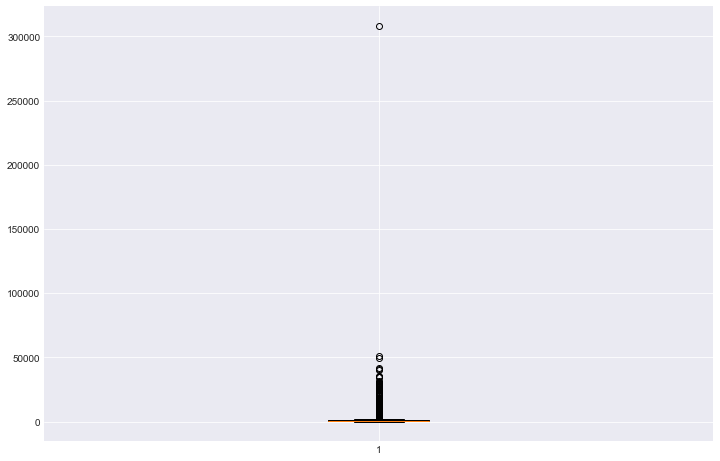

In [3]:
plt.figure(figsize=(12, 8))
plt.boxplot(train.groupby('item_id').mean().item_price.values)
plt.show()

> We can see a big outlier, and some small outliers at 5000 also it looks like that some item is below 0

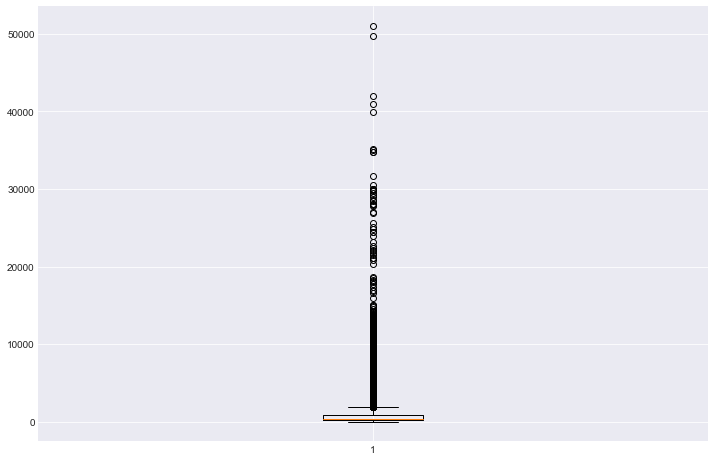

In [4]:
plt.figure(figsize=(12, 8))
plt.boxplot(train[train.item_price<100000].groupby('item_id').mean().item_price.values)
plt.show()

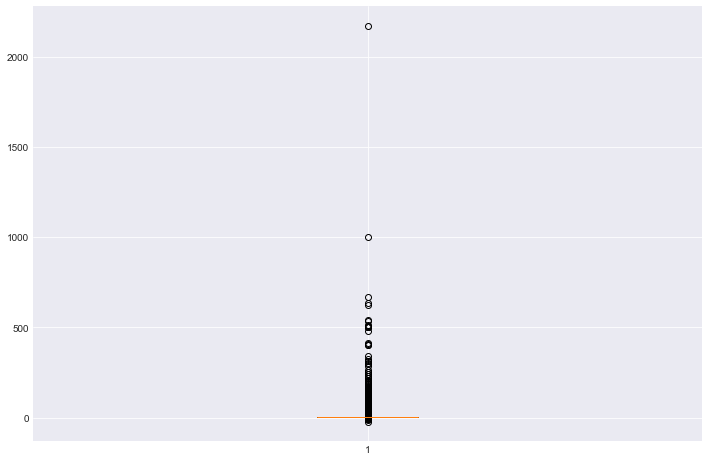

In [5]:
plt.figure(figsize=(12, 8))
plt.boxplot(train.item_cnt_day.values)
plt.show()

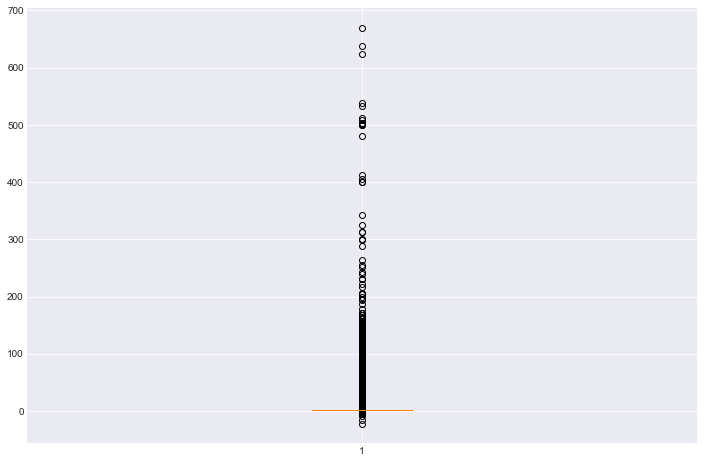

In [6]:
plt.figure(figsize=(12, 8))
plt.boxplot(train[train.item_cnt_day<1000].item_cnt_day.values)
plt.show()

In [7]:
train.shape[0] - train[(train.item_price<100000)&(train.item_cnt_day<600)&(train.item_price > 0)].shape[0]

7

In [8]:
train = train[(train.item_price<100000)&(train.item_cnt_day<1000)&(train.item_price > 0)]

In [10]:
print(test.shape, train.shape)

(214200, 3) (2935845, 6)


In [14]:
#Same stores
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'

### Now the test dataset is a combination of all valid itens with all valid stores, while the training is only sales dataframe, so basically we're adding all the the valid itens to the stores as 0

In [102]:
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [134]:
df = [] 
index_cols = ['shop_id', 'item_id', 'date_block_num']
for block_num in train['date_block_num'].unique():
    cur_shops = train.loc[train['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = train.loc[train['date_block_num'] == block_num, 'item_id'].unique()
    df.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

df = pd.DataFrame(np.vstack(df), columns = index_cols,dtype=np.int32)

#Add month train
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': 'sum', 'item_price':'mean'})
group.columns = ['item_cnt_month', 'item_price']
group.reset_index(inplace=True)

df = pd.merge(df, group, on=index_cols, how='left')
df['item_cnt_month'] = (df['item_cnt_month']
                                .fillna(0)
                                .clip(0,20)
                                .astype(np.float16))

test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)
train_df = pd.concat([df, test], ignore_index=True, sort=False, keys=index_cols)
train_df.ID=train_df.ID.fillna(0).astype(int)

## Feature engineering
> We'll start encoding many variables from labels refering to a item's name, or an item's category or the shop they were sold.
<br> We could call this <i>NLP</i> but all I'm doing here really is extracting common words in the labels and transforming into binary categorical variables, if the item/shop/item category has or does not have a word.
<br>As we cant afford to encode all items and itens categories, we'll just get some top terms from each data set

## Item categories

In [180]:
print(item_categories.shape)

(84, 45)


In [182]:
from collections import Counter 
all_labels = (' ').join(item_categories.item_category_name.to_list()).split()
Counter_itens = Counter(all_labels)
Counter_itens.most_common(20)

[('-', 77),
 ('Игры', 14),
 ('Книги', 13),
 ('Подарки', 12),
 ('Аксессуары', 8),
 ('Игровые', 8),
 ('консоли', 8),
 ('(Цифра)', 7),
 ('XBOX', 6),
 ('Музыка', 6),
 ('Программы', 6),
 ('PC', 5),
 ('Карты', 5),
 ('оплаты', 5),
 ('Кино', 5),
 ('Цифра', 4),
 ('издания', 4),
 ('литература', 4),
 ('PS2', 3),
 ('PS3', 3)]

In [183]:
def word_checker(string, x):
    if x in string: 
        return 1
    else:
        return 0
frequent_categories=['Игры','Книги','Подарки','Аксессуары','Игровые','консоли','(Цифра)','XBOX','Музыка','Программы','PC','Карты','оплаты','Кино','Цифра','издания','литература','PS2','PS3','PS4']
for i in frequent_categories:
    column_name = 'has_{}'.format(i)
    item_categories[column_name]=item_categories.item_category_name.apply(lambda x: word_checker(x, i))

In [184]:
item_categories.head()

,item_category_name,item_category_id,has_Игры,has_Книги,has_Подарки,has_Аксессуары,has_Игровые,has_консоли,has_(Цифра),has_XBOX,...,has_PC,has_Карты,has_оплаты,has_Кино,has_Цифра,has_издания,has_литература,has_PS2,has_PS3,has_PS4
0,PC - Гарнитуры/Наушники,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,Аксессуары - PS2,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,Аксессуары - PS3,2,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,Аксессуары - PS4,3,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,Аксессуары - PSP,4,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Item names

In [185]:
print(items.shape)
items.item_name

(22170, 3)


0                ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D
1        !ABBYY FineReader 12 Professional Edition Full...
2            ***В ЛУЧАХ СЛАВЫ   (UNV)                    D
3          ***ГОЛУБАЯ ВОЛНА  (Univ)                      D
4              ***КОРОБКА (СТЕКЛО)                       D
                               ...                        
22165               Ядерный титбит 2 [PC, Цифровая версия]
22166      Язык запросов 1С:Предприятия  [Цифровая версия]
22167    Язык запросов 1С:Предприятия 8 (+CD). Хрустале...
22168                                  Яйцо для Little Inu
22169                        Яйцо дракона (Игра престолов)
Name: item_name, Length: 22170, dtype: object

In [186]:
#The following line apply the same logic from above, but removes special characters
all_labels = (' ').join(re.sub('[^A-Za-z0-9а-яА-Я ]+', '', word) for word in items.item_name.to_list()).split()
Counter_itens = Counter(all_labels)
Counter_itens.most_common(50)

[('версия', 3567),
 ('PC', 2547),
 ('BD', 2006),
 ('Цифровая', 1994),
 ('регион', 1500),
 ('русская', 1430),
 ('2', 1406),
 ('Jewel', 1163),
 ('3', 912),
 ('1', 897),
 ('The', 889),
 ('mp3CD', 774),
 ('Xbox', 738),
 ('PS3', 724),
 ('фирм', 707),
 ('Edition', 676),
 ('и', 617),
 ('И', 604),
 ('Фигурка', 599),
 ('360', 565),
 ('для', 554),
 ('3D', 531),
 ('LP', 519),
 ('of', 518),
 ('В', 437),
 ('2CD', 431),
 ('Of', 427),
 ('4', 413),
 ('в', 409),
 ('субтитры', 402),
 ('русские', 401),
 ('DVD', 373),
 ('Футболка', 356),
 ('коллекция', 349),
 ('digipack', 349),
 ('на', 348),
 ('Регион', 342),
 ('игра', 342),
 ('английская', 339),
 ('СБ', 333),
 ('7', 309),
 ('Мягкая', 302),
 ('1САудиокниги', 298),
 ('с', 296),
 ('арт', 291),
 ('VA', 286),
 ('игрушка', 286),
 ('документация', 284),
 ('издание', 279),
 ('Assassins', 279)]

In [187]:
items_labels=['версия','PC','BD','Цифровая','регион','русская','2','Jewel','3','1','The','mp3CD','Xbox','PS3','фирм','Edition','Фигурка','360','для','3D','LP','В','2CD','Of','4','в','субтитры','русские','DVD','Футболка','коллекция','digipack','на','Регион','игра','английская','СБ','7','Мягкая','1САудиокниги','с','арт','VA','игрушка','документация','издание','Assassins']
items_labels_clean=[x for x in items_labels if x not in frequent_categories]

In [188]:
for i in items_labels_clean:
    items['has_{}'.format(i)] = items.item_name.apply(lambda x: word_checker(x, i))

In [189]:
items.head()

,item_name,item_id,item_category_id,has_версия,has_BD,has_Цифровая,has_регион,has_русская,has_2,has_Jewel,...,has_7,has_Мягкая,has_1САудиокниги,has_с,has_арт,has_VA,has_игрушка,has_документация,has_издание,has_Assassins
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,!ABBYY FineReader 12 Professional Edition Full...,1,76,1,0,1,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,***КОРОБКА (СТЕКЛО) D,4,40,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [190]:
items_df=pd.merge(items.drop('item_name', axis=1),item_categories.drop('item_category_name', axis=1), on='item_category_id')
items_df = items_df.T.drop_duplicates(keep='first').T

In [191]:
items_df.head()

,item_id,item_category_id,has_версия,has_BD,has_Цифровая,has_регион,has_русская,has_2,has_Jewel,has_3,...,has_Программы,has_PC,has_Карты,has_Кино,has_Цифра,has_издания,has_литература,has_PS2,has_PS3,has_PS4
0,0,40,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,2,40,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,3,40,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,4,40,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,5,40,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [193]:
#We're encoding this since russian lg not supported in many applications
items_df.columns=['item_id', 'item_category_id','fl_item1','fl_item2','fl_item3','fl_item4','fl_item5','fl_item6','fl_item7','fl_item8','fl_item9','fl_item10','fl_item11','fl_item12','fl_item13','fl_item14','fl_item15','fl_item16','fl_item17','fl_item18','fl_item19','fl_item20','fl_item21','fl_item22','fl_item23','fl_item24','fl_item25','fl_item26','fl_item27','fl_item28','fl_item29','fl_item30','fl_item31','fl_item32','fl_item33','fl_item34','fl_item35','fl_item36','fl_item37','fl_item38','fl_item39','fl_item40','fl_item41','fl_item42','fl_item43','fl_item44','fl_item45','fl_item46','fl_item47','fl_item48','fl_item49','fl_item50','fl_item51','fl_item52','fl_item53','fl_item54','fl_item55','fl_item56','fl_item57','fl_item58','fl_item59','fl_item60','fl_item61','fl_item62']
for flag in ['fl_item1','fl_item2','fl_item3','fl_item4','fl_item5','fl_item6','fl_item7','fl_item8','fl_item9','fl_item10','fl_item11','fl_item12','fl_item13','fl_item14','fl_item15','fl_item16','fl_item17','fl_item18','fl_item19','fl_item20','fl_item21','fl_item22','fl_item23','fl_item24','fl_item25','fl_item26','fl_item27','fl_item28','fl_item29','fl_item30','fl_item31','fl_item32','fl_item33','fl_item34','fl_item35','fl_item36','fl_item37','fl_item38','fl_item39','fl_item40','fl_item41','fl_item42','fl_item43','fl_item44','fl_item45','fl_item46','fl_item47','fl_item48','fl_item49','fl_item50','fl_item51','fl_item52','fl_item53','fl_item54','fl_item55','fl_item56','fl_item57','fl_item58','fl_item59','fl_item60','fl_item61','fl_item62']:
    items_df[flag]=items_df[flag].astype('int8')

### Shops
> Thanks to this kaggle notebook (https://www.kaggle.com/dlarionov/feature-engineering-xgboost) I know that the first word from each entry in this "shops" dataframe is actually the city they're located. So instead of doing the same as above I'll just code the cities in each shop is located

In [45]:
print(shops.shape)
shops.head()

(60, 2)


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [66]:
shops['city'] = shops['shop_name'].apply(lambda x: x.split()[0].lower())
shops.loc[shops.city == '!якутск', 'city'] = 'якутск'
shops.loc[shops.city == 'Якутск', 'city'] = 'якутск'

In [67]:
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])

#### Another useful info that I got from those kaggles notebooks are the coordinates and country part

In [69]:
coords = dict()
coords['якутск'] = (62.028098, 129.732555, 4)
coords['адыгея'] = (44.609764, 40.100516, 3)
coords['балашиха'] = (55.8094500, 37.9580600, 1)
coords['волжский'] = (53.4305800, 50.1190000, 3)
coords['вологда'] = (59.2239000, 39.8839800, 2)
coords['воронеж'] = (51.6720400, 39.1843000, 3)
coords['выездная'] = (0, 0, 0)
coords['жуковский'] = (55.5952800, 38.1202800, 1)
coords['интернет-магазин'] = (0, 0, 0)
coords['казань'] = (55.7887400, 49.1221400, 4)
coords['калуга'] = (54.5293000, 36.2754200, 4)
coords['коломна'] = (55.0794400, 38.7783300, 4)
coords['красноярск'] = (56.0183900, 92.8671700, 4)
coords['курск'] = (51.7373300, 36.1873500, 3)
coords['москва'] = (55.7522200, 37.6155600, 1)
coords['мытищи'] = (55.9116300, 37.7307600, 1)
coords['н.новгород'] = (56.3286700, 44.0020500, 4)
coords['новосибирск'] = (55.0415000, 82.9346000, 4)
coords['омск'] = (54.9924400, 73.3685900, 4)
coords['ростовнадону'] = (47.2313500, 39.7232800, 3)
coords['спб'] = (59.9386300, 30.3141300, 2)
coords['самара'] = (53.2000700, 50.1500000, 4)
coords['сергиев'] = (56.3000000, 38.1333300, 4)
coords['сургут'] = (61.2500000, 73.4166700, 4)
coords['томск'] = (56.4977100, 84.9743700, 4)
coords['тюмень'] = (57.1522200, 65.5272200, 4)
coords['уфа'] = (54.7430600, 55.9677900, 4)
coords['химки'] = (55.8970400, 37.4296900, 1)
coords['цифровой'] = (0, 0, 0)
coords['сергиевпосад']= (0, 0, 0)
coords['чехов'] = (55.1477000, 37.4772800, 4)
coords['ярославль'] = (57.6298700, 39.8736800, 2) 

shops['city_coord_1'] = shops['city'].apply(lambda x: coords[x][0])
shops['city_coord_2'] = shops['city'].apply(lambda x: coords[x][1])
shops['country_part'] = shops['city'].apply(lambda x: coords[x][2])

shops = shops[['shop_id', 'city_code', 'city_coord_1', 'city_coord_2', 'country_part']]

## "Fancy features"

> I'm calling this section "fancy features" because we'll use other ML models to generate <b>variables</b> for our final model. So first I want to create two different variables to characterize or give some idea about the following aspects:
1. How much different items that store sold at the training period?
2. How much the itens in the store "rotates" monthly?

In [70]:
train_shops=train.shop_id.unique()
test_shops = test.shop_id.unique()

In [71]:
set(test_shops).issubset(set(train_shops))

True

In [72]:
test_shops[~np.in1d(test_shops, train_shops)] #Second check just because I'm insecure

array([], dtype=int8)

In [73]:
train_itens=train.item_id.unique()
test_itens = test.item_id.unique()
set(test_itens).issubset(set(train_itens))

False

In [74]:
len(test_itens[~np.in1d(test_itens, train_itens)])

363

In [75]:
new_itens=test_itens[~np.in1d(test_itens, train_itens)]

* The anwser is that all of elements in test shop are in train shop so: we're good to go, we also check for items, but itens contains new products, we'll be addressing them later in this notebook

In [81]:
train_DI=train[(train.date_block_num<=32)][['shop_id','item_id']].groupby('shop_id').nunique() #We'll not be using the data used for testing. This will only be used to "fit"
DI=train[['shop_id','item_id']].groupby('shop_id').nunique() #This will only be used to predict

> We'll use period>28 as our test period so we dont want to contaminate our data

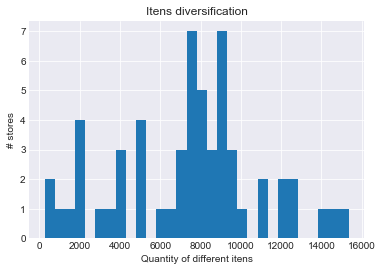

In [82]:
plt.hist(DI.item_id,bins=30)
plt.title('Itens diversification')
plt.xlabel('Quantity of different itens')
plt.ylabel('# stores')
plt.show()

#### We could classify the stores using some exploratory analysis, we could classify stores with 'low diversity of itens', 'medium diversity' and stores with 'high diversity' but since I want to be more precise and have a logical decision making I'll use a simple k-means in the series alone to find this clusters
> We're using k-means because it's a simple alghrotim for a simple problem, we just want to identify 3 different cluster which optimizes the separation from those clusters

In [83]:
from sklearn.cluster import KMeans
kmean=KMeans(n_clusters=3, random_state=42)
kmean.fit(train_DI.item_id.values.reshape(-1, 1))
groups=kmean.predict(DI.item_id.values.reshape(-1, 1))

In [84]:
DI['store_size']=groups

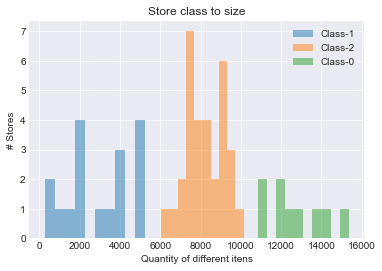

In [85]:
plt.hist(DI[DI.store_size==1].item_id,alpha=0.5, label='Class-1')
plt.hist(DI[DI.store_size==2].item_id,alpha=0.5, label='Class-2')
plt.hist(DI[DI.store_size==0].item_id,alpha=0.5, label='Class-0')
plt.title('Itens diversification')
plt.xlabel('Quantity of different itens')
plt.ylabel('# stores')
plt.legend()
plt.title('Store class to size')
plt.xlabel('Quantity of different itens')
plt.ylabel('# Stores')
plt.show()

> However this cluster is only analyzing the whole dataset's diversity, how it's item variety per month? <br>
* To anwser this we'll need to check for item diversity between the months <br>
* With this we'll also have an information if the store is currently open or not (data leakage) and how old is this store<br>

In [86]:
itens_at_months=[]
itens_at_months_train=[]
for i in range(0,33):
    itens_at_months.append('item_id_at_{}'.format(i))
    DI['item_id_at_{}'.format(i)]=train[(train.date_block_num==i)&(train.item_cnt_day>0)][['shop_id','item_id']].groupby('shop_id').nunique().item_id = train[train.date_block_num==i][['shop_id','item_id']].groupby('shop_id').nunique().item_id
    if i<=30:
        itens_at_months_train.append('item_id_at_{}'.format(i))
        train_DI['item_id_at_{}'.format(i)]=train[(train.date_block_num==i)&(train.item_cnt_day>0)][['shop_id','item_id']].groupby('shop_id').nunique().item_id = train[train.date_block_num==i][['shop_id','item_id']].groupby('shop_id').nunique().item_id

> So we're applying the same logic as above, but we're only using item variety insiede a month. This because we want to track if a store really does offers a lot of itens or just have a high item rotation.

In [88]:
DI_group=DI[itens_at_months].median(axis=1).values.reshape(-1, 1)
DI_group[33][0]=0

In [89]:
kmean=KMeans(n_clusters=3, random_state=42)
kmean.fit(train_DI[itens_at_months_train].median(axis=1).values.reshape(-1, 1))
groups=kmean.predict(DI_group)

In [90]:
DI['store_size_per_month']=groups

> Let's visualize using total item diversification

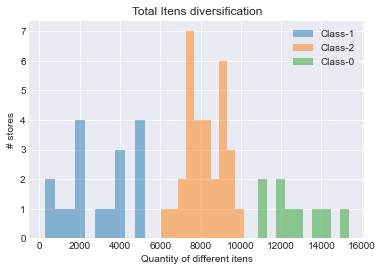

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


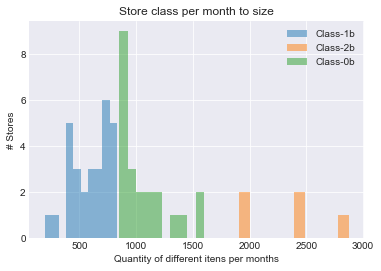

In [91]:
plt.hist(DI[DI.store_size==1].item_id,alpha=0.5, bins=10, label='Class-1')
plt.hist(DI[DI.store_size==2].item_id,alpha=0.5, bins=10, label='Class-2')
plt.hist(DI[DI.store_size==0].item_id,alpha=0.5, bins=10, label='Class-0')
plt.title('Total Itens diversification')
plt.xlabel('Quantity of different itens')
plt.ylabel('# stores')
plt.legend()
plt.show()

plt.hist(DI[DI.store_size_per_month==1][itens_at_months].median(axis=1).values,alpha=0.5, bins=10, label='Class-1b')
plt.hist(DI[DI.store_size_per_month==2][itens_at_months].median(axis=1).values,alpha=0.5, bins=10, label='Class-2b')
plt.hist(DI[DI.store_size_per_month==0][itens_at_months].median(axis=1).values,alpha=0.5, bins=10, label='Class-0b')

plt.title('Store class per month to size')
plt.xlabel('Quantity of different itens per months')
plt.ylabel('# Stores')
plt.legend()
plt.show()

In [92]:
import seaborn as sns

#### These two variables are obviously correlated, but do they overlap completely?

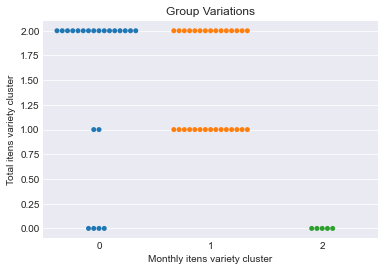

In [93]:
sns.swarmplot(x='store_size_per_month', y='store_size', data=DI)
plt.title('Group Variations')
plt.xlabel('Monthly itens variety cluster')
plt.ylabel('Total itens variety cluster')
plt.show()

In [97]:
shop_df=pd.merge(shops,DI.drop('shop_id',axis=1).reset_index()[['shop_id','store_size','store_size_per_month']], on='shop_id')

In [108]:
train_df

,shop_id,item_id,date_block_num,item_cnt_month,item_price,ID
0,59,22154,0,1.0,999.0,0
1,59,2552,0,0.0,0.0,0
2,59,2554,0,0.0,0.0,0
3,59,2555,0,0.0,0.0,0
4,59,2564,0,0.0,0.0,0
...,...,...,...,...,...,...
11127999,45,18454,34,0.0,0.0,214195
11128000,45,16188,34,0.0,0.0,214196
11128001,45,15757,34,0.0,0.0,214197
11128002,45,19648,34,0.0,0.0,214198


### Time based variables - Lagged features

We're taking advantage from the feature "date_block_num" which has already encoded the order of the months!

In [135]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', '{}_last_{}month'.format(col, i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
        df['{}_last_{}month'.format(col, i)] = df['{}_last_{}month'.format(col, i)].astype('float16')
    return df

In [158]:
def drv_cols_lags(df, lags, cols):
    tmp=df.copy()
    for col in cols:
        print('Treating col:{}'.format(col))
        timeline=[]
        last_month='{}_last_1month'.format(col)
        for i in lags:
            print('For {} lagged months'.format(i))
            current='{}_last_{}month'.format(col, i)
            timeline.append(current)
            tmp['last_{}_compared_{}_months'.format(col, i)] =(tmp[last_month].fillna(0)/(tmp[last_month]+tmp[current])).fillna(0)
            tmp['last_{}_avg_{}_months'.format(col, i)] =(tmp[[last_month]+timeline]).fillna(0).mean(axis=1)
            tmp['last_month_compared_{}avg'.format(col, i)]= (tmp[last_month].fillna(0)/tmp['last_{}_avg_{}_months'.format(col, i)])
    return tmp

#### Let's start with basic lagging features

In [138]:
train_df['revenue']=train_df['item_cnt_month']*train_df['item_price']
train_df=lag_feature(train_df, [1, 2, 3], 'revenue')
train_df=lag_feature(train_df, [1], 'item_price')
train_df=lag_feature(train_df, [1, 2, 3], 'item_cnt_month')

In [160]:
#This one will generate some extra fatures that could be interesting:
# 'last_{}_compared_{}_months': How much does the last month contributes for target/revenue totals in the (rolling) "trimester"?
# 'last_{}_avg_{}_months': how the item in the shop performed in average in the lag window starting last month?
# 'last_month_compared_{}avg': How much does the last sales deviates from the "normal"?
train_df=drv_cols_lags(train_df, [2, 3], ['revenue', 'item_cnt_month'])

Treating col:revenue
For 2 lagged months


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:38: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


For 3 lagged months
Treating col:item_cnt_month
For 2 lagged months
For 3 lagged months


### Now adding basic encoding about featuring itens (item_is_featured_global), if the item has been sold before in the store (shop_item_sold_before), and if the shop inauguration (shop_is_opening)

In [202]:
first_shop_item_buy_block = group[group['date_block_num'] > 0].groupby(['shop_id', 'item_id'])['date_block_num'].min().reset_index()
first_shop_item_buy_block['first_date_block_num'] = first_shop_item_buy_block['date_block_num']

In [204]:
train_df = pd.merge(train_df, first_shop_item_buy_block[['item_id', 'shop_id', 'first_date_block_num']], on=['item_id', 'shop_id'], how='left')
train_df['first_date_block_num'].fillna(100, inplace=True)
train_df['shop_item_sold_before'] = (train_df['first_date_block_num'] < train_df['date_block_num']).astype('int8')
train_df.drop(['first_date_block_num'], axis=1, inplace=True)

In [205]:
first_sale=train[['item_id','date_block_num']].groupby(['item_id']).min().reset_index()
first_sale['item_is_featured_global'] = 1
shop_opening = train[['shop_id','date_block_num']].groupby(['shop_id']).min().reset_index()
shop_opening['shop_is_opening'] = 1

In [210]:
train_df['item_is_featured_global']=pd.merge(train_df,first_sale,how='left',on=['date_block_num', 'item_id']).item_is_featured_global.fillna(0)
train_df['shop_is_opening']=pd.merge(train_df,shop_opening,how='left',on=['date_block_num', 'shop_id']).shop_is_opening.fillna(0)

### Comparing the performance of a sale with global levels of performance (sale in a store / sales in all stores per example), we'll do this to item price and ou target!

In [224]:
#Comparative using sales by shops and itens
def comp_feats(df, index_cols, name, col):
    group = train.groupby(index_cols)[col].mean().reset_index().rename(columns={col: "avg_{}_{}".format(name, col)}, errors="raise")
    df_f = pd.merge(df, group, on=index_cols, how='left')
    print(df_f["avg_{}_{}".format(name, col)])
    df_f["avg_{}_{}".format(name, col)] = df_f["avg_{}_{}".format(name, col)].fillna(0).astype(np.float16)
    return df_f

train_df = comp_feats(train_df, ['item_id', 'date_block_num'], 'global', 'item_price')

train_df['item_shop_price_avg'] = (train_df['item_price'] - train_df['avg_global_item_price']) / train_df['avg_global_item_price']
train_df['item_shop_price_avg'].fillna(0, inplace=True)
train_df['price_dev']= ((train_df['item_price_last_1month']-train_df['item_price'])/train_df['item_price']).fillna(0)

train_df = lag_feature(train_df, [1], 'price_dev')
train_df = lag_feature(train_df, [1, 2], 'item_shop_price_avg')
train_df.drop(['item_price', 'avg_global_item_price', 'item_shop_price_avg','price_dev', 'revenue'], axis=1, inplace=True)

train_df.columns.values

array(['shop_id', 'item_id', 'date_block_num', 'item_cnt_month', 'ID',
       'revenue_last_1month', 'revenue_last_2month',
       'revenue_last_3month', 'item_price_last_1month',
       'item_cnt_month_last_1month', 'item_cnt_month_last_2month',
       'item_cnt_month_last_3month', 'last_revenue_compared_2_months',
       'last_revenue_avg_2_months', 'last_month_compared_revenueavg',
       'last_revenue_compared_3_months', 'last_revenue_avg_3_months',
       'last_item_cnt_month_compared_2_months',
       'last_item_cnt_month_avg_2_months',
       'last_month_compared_item_cnt_monthavg',
       'last_item_cnt_month_compared_3_months',
       'last_item_cnt_month_avg_3_months', 'shop_item_sold_before',
       'item_is_featured_global', 'shop_is_opening',
       'price_dev_last_1month', 'item_shop_price_avg_last_1month',
       'item_shop_price_avg_last_2month'], dtype=object)

In [236]:
train_df = comp_feats(train_df, ['item_id', 'date_block_num'], 'global', 'item_cnt_day')
train_df['item_cnt_percentage']=train_df['item_cnt_month']/train_df['avg_global_item_cnt_day']

train_df = lag_feature(train_df.rename(columns={'avg_global_item_cnt_day':'avg_global_item_cnt_month'}), [1, 2, 3], 'avg_global_item_cnt_month')
train_df = lag_feature(train_df,[1, 2, 3], 'item_cnt_percentage')

train_df.drop(['avg_global_item_cnt_month', 'item_cnt_percentage'], axis=1, inplace=True)

In [238]:
print(train_df.shape)
train_final = pd.merge(train_df.fillna(0),items_df, on='item_id', suffixes=['','_2'])
print(train_final.shape)

(11128004, 34)
(11128004, 97)


In [243]:
train_final.columns.values

array(['shop_id', 'item_id', 'date_block_num', 'item_cnt_month', 'ID',
       'revenue_last_1month', 'revenue_last_2month',
       'revenue_last_3month', 'item_price_last_1month',
       'item_cnt_month_last_1month', 'item_cnt_month_last_2month',
       'item_cnt_month_last_3month', 'last_revenue_compared_2_months',
       'last_revenue_avg_2_months', 'last_month_compared_revenueavg',
       'last_revenue_compared_3_months', 'last_revenue_avg_3_months',
       'last_item_cnt_month_compared_2_months',
       'last_item_cnt_month_avg_2_months',
       'last_month_compared_item_cnt_monthavg',
       'last_item_cnt_month_compared_3_months',
       'last_item_cnt_month_avg_3_months', 'shop_item_sold_before',
       'item_is_featured_global', 'shop_is_opening',
       'price_dev_last_1month', 'item_shop_price_avg_last_1month',
       'item_shop_price_avg_last_2month',
       'avg_global_item_cnt_month_last_1month',
       'avg_global_item_cnt_month_last_2month',
       'avg_global_item_cnt_m

#### Now we have many new itens in the test set so we need to encode some variables about that!

In [245]:
item_id_target_mean = train_final[train_final['item_is_featured_global'] == 1].groupby(['date_block_num','item_category_id', 'shop_id'])['item_cnt_month'].mean().reset_index().rename(columns={
    "item_cnt_month": "new_item_shop_cat_avg"}, errors="raise")

train_final = pd.merge(train_final, item_id_target_mean, on=['date_block_num','item_category_id', 'shop_id'], how='left')

train_final['new_item_shop_cat_avg'] = (train_final['new_item_shop_cat_avg']
                                .fillna(0)
                                .astype(np.float16))

train_final = lag_feature(train_final, [1, 2, 3], 'new_item_shop_cat_avg')
train_final.drop(['new_item_shop_cat_avg'], axis=1, inplace=True)

In [250]:
 item_id_target_mean = train_final[train_final['item_is_featured_global'] == 1].groupby(['date_block_num','shop_id'])['item_cnt_month'].mean().reset_index().rename(columns={
    "item_cnt_month": 'new_item_shop_avg'}, errors="raise")

train_final = pd.merge(train_final, item_id_target_mean, on=['date_block_num', 'shop_id'], how='left')

train_final['new_item_shop_avg'] = (train_final['new_item_shop_avg']
                                .fillna(0)
                                .astype(np.float16))

train_final = lag_feature(train_final, [1, 2, 3], 'new_item_shop_avg')
train_final.drop(['new_item_shop_avg'], axis=1, inplace=True)

In [251]:
print(train_final.shape)
train_final = pd.merge(train_final,shop_df, on='shop_id', suffixes=['','_2'])
print(train_final.shape)

(11128004, 103)
(11128004, 109)


In [257]:
#Now this one feature was created in kaggle and it seems to greatly improve score, so:
def lag_feature_adv(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)+'_adv']
        shifted['date_block_num'] += i
        shifted['item_id'] -= 1
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
        df[col+'_lag_'+str(i)+'_adv'] = df[col+'_lag_'+str(i)+'_adv'].astype('float16')
    return df

train_final = lag_feature_adv(train_final, [1, 2, 3], 'item_cnt_month')

In [258]:
train_final.to_csv('raw_df.csv')

In [ ]:
# train_final=pd.read_csv('raw_df.csv')
# x_train=train_final[(train_final.date_block_num>12)&(train_final.date_block_num<32)]
# x_test=train_final[(train_final.date_block_num>=32)&(train_final.date_block_num<34)]
# test=train_final[train_final.date_block_num==34]

* With this dataset (x_train and x_test) I was able to get a fairly good boardscore (~ 0.95 RMSE) with lgboost without much parameter tuning. But we'll add even more features from other models.

## Stacking models

> Now the data that we presented here until now is just some data preparation and feature extraction from data.
<br> But what if we use the output from a model to use as a variable to our final model?
<br> In this section we'll generate more features using many ML applications
* We'll not use the whole dataset for this, because we need to validate our model and train our final model!

<br> Note: this here is a checkpoint, so there'll be some repeated imports and function definitions

## Conclusion
* In this notebook we showed we were able to generate over 220 new variables deriving only from the original dataframes.
* For ML modeling see the next notebook